# Uncapacitated-Facility-Location models with Python/Gurobi
## [Jon Lee](https://sites.google.com/site/jonleewebpage/home), 10/20/2020

The base model that we work with is
\begin{align*}
\min~& \sum_{i\in M} f_i y_i +\sum_{i\in M} \sum_{j \in N} c_{ij}x_{ij}\\
&\sum_{i \in M} x_{ij} = 1,~ \mbox{ for } j \in N;\\
& x_{ij} \geq 0,~ \mbox{ for } i \in M,~ j \in N;\\
& 0\leq y_i \leq 1,~ \mbox{ and integer, } \mbox{for } i \in M.
\end{align*}

Notes:
* We make two solves, first with the weak forcing constraints
\begin{equation*}
\sum_{j\in N} x_{ij} \leq n~y_i,~ \mbox{for } i \in M,
\end{equation*}
and then with the strong forcing constraints
\begin{equation*}
x_{ij} \leq y_i,~ \mbox{for } i \in M,~ j \in N.
\end{equation*}
* Random instances with $m$ facilities and $n$ customers. Play with $m,n$ and possibly with $demand$ and scale factor in $f$.

References:
* Jon Lee, "A First Course in Linear Optimization", Fourth Edition (Version 4.0), Reex Press, 2013-20.

MIT License

Copyright (c) 2020 Jon Lee

Permission is hereby granted, free of charge, to any person obtaining a copy 
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

In [1]:
%reset -f
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
import gurobipy as gp
from gurobipy import GRB

class StopExecution(Exception):
    def _render_traceback_(self):
        pass

In [2]:
# parameters
m=75                   # number of facilities
n=4000                  # number of customers
M=list(range(0,m))      
N=list(range(0,n))      
np.random.seed(10)      # set seed to be able to repeat the same random data
solveLPsOnly=False      # set True to only solve LP relaxations

# random locations in the unit square
fPx=np.random.rand(m)
fPy=np.random.rand(m)
cPx=np.random.rand(n)
cPy=np.random.rand(n)


# cost data
demand=10*np.random.rand(n)  # these will be 'baked' into the shipping costs 
f=200*np.random.rand(m)  # facility costs
c=np.zeros((m,n))
for i in range(0,m):
    for j in range(0,n):
        c[i,j]=demand[j]*np.sqrt(np.square(fPx[i]-cPx[j])+np.square(fPy[i]-cPy[j]))     
                # = demand times per-unit transportation costs (distance) 

In [3]:
# set up the weak model
model = gp.Model()
#model.setParam('Threads', 1)                   # uncomment to ask for 1 thread
if solveLPsOnly==True:
    y=model.addVars(m,ub=1.0)                     
else:
    y=model.addVars(m,vtype=GRB.BINARY)   
x=model.addVars(m,n)
model.setObjective(sum(f[i]*y[i] for i in M) + sum(c[i,j]*x[i,j] for i in M for j in N), GRB.MINIMIZE)
demandconstraints = model.addConstrs(x.sum('*',j) == 1 for j in N)
weakforceconstraints = model.addConstrs(x.sum(i,'*') <= n*y[i]  for i in M)

Academic license - for non-commercial use only - expires 2021-08-26
Using license file C:\Users\jonxlee\gurobi.lic
Discarded solution information


In [4]:
# solve the weak model
model.optimize()
if model.status != GRB.Status.OPTIMAL:
    print("***** Gurobi solve status:", model.status)
    print("***** This is a problem. Model does not have an optimal solution")
    raise StopExecution
for i in M: print("y[",i,"]=",round(y[i].X,4))
ytot=round(sum (y[i].X for i in M))
print("y total =",ytot)

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 4075 rows, 300075 columns and 600075 nonzeros
Model fingerprint: 0xfc880efe
Variable types: 300000 continuous, 75 integer (75 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [3e-04, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 17544.136375
Presolve time: 1.10s
Presolved: 4075 rows, 300075 columns, 600075 nonzeros
Variable types: 300000 continuous, 75 integer (75 binary)

Root relaxation: objective 1.229656e+03, 597 iterations, 0.14 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1229.65553    0   75 17544.1364 1229.65553  93.0%     -    2s
H    0     0                    8324.6715293 1229.65553  85.2%     -    2

In [5]:
# set up and solve the strong model
model.reset()
model.remove(weakforceconstraints)
strongforceconstraints = model.addConstrs(x[i,j] <= y[i]  for i in M for j in N)
model.optimize()
if model.status != GRB.Status.OPTIMAL:
    print("***** Gurobi solve status:", model.status)
    print("***** This is a problem. Model does not have an optimal solution")
    raise StopExecution
for i in M: print("y[",i,"]=",round(y[i].X,4))
ytot=round(sum (y[i].X for i in M))
print("y total =",ytot)

Discarded solution information
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 304000 rows, 300075 columns and 900000 nonzeros
Model fingerprint: 0xdcd5646b
Variable types: 300000 continuous, 75 integer (75 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-04, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 17544.136375
Presolve time: 1.37s
Presolved: 304000 rows, 300075 columns, 900000 nonzeros
Variable types: 300000 continuous, 75 integer (75 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.03s

Solved with dual simplex

Root relaxation: objective 2.538426e+03, 11556 iterations, 1.25 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumben

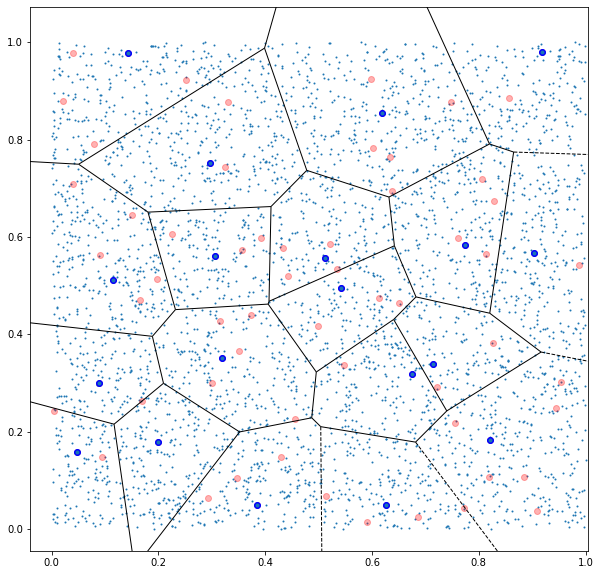

In [6]:
# plot the results
#
if solveLPsOnly == False:
    fxopen=np.zeros(ytot)
    fyopen=np.zeros(ytot)
    count=-1
    for i in M:
        if round(y[i].X)==1:
            count += 1
            fxopen[count]=fPx[i]
            fyopen[count]=fPy[i]
        
    # Get current figure size
    fig_size = plt.rcParams["figure.figsize"]
    #print("Current size:", fig_size)
    fig_size[0] = 10
    fig_size[1] = 10
    plt.rcParams["figure.figsize"] = fig_size
    
    # vornoi diagram for the open facilities
    points=np.column_stack((fxopen,fyopen))
    vor = Voronoi(points)
    fig = voronoi_plot_2d(vor,show_vertices=False)

    # open facilities are blue, closed failities are opaque red, 
    #   vornoi cells capture the customers assigned to each open facility
    plt.scatter(cPx,cPy,s=1)
    plt.scatter(fPx,fPy,c='red',alpha=0.3)
    plt.scatter(fxopen,fyopen,c='blue')